# Deep Learning &mdash; Assignment 4

Fourth assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:**
Daan Brugmans, Maximilian Pohl

**Group:**
31

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

**Note:**

* The models in this assignment take a while to train. It is faster on a GPU (e.g., on Google Colab), but still doable on a CPU. Plan ahead to leave enough time to analyse your results.

## Objectives

In this assignment you will
1. Implement an LSTM module from scratch.
2. Use the built-in LSTM module from PyTorch.
3. Compare fully connected and recurrent neural networks in an experiment.
4. Experiment with data augmentation.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [1]:
%matplotlib inline
import csv
import glob
import re
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l

# fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

## 4.1 Dataset: Atrial fibrillation classification on ECG recordings (1 point)

In this assignment we will work with data from the [PhysioNet Computing in Cardiology Challenge 2017](https://physionet.org/content/challenge-2017/1.0.0/) to classify atrial fibrillation in electrocardiograms (ECGs). Atrial fibrillation is an abnormal heart rhythm, which can be recognized as irregular patterns in ECG recordings.

**(a) Download the [training dataset](https://physionet.org/files/challenge-2017/1.0.0/training2017.zip) from the challenge website and extract the files.**

In [2]:
# NOTE: Commented out so that the file is not installed again when rerunning the entire notebook.
# !mkdir -p data
# !wget -c -O data/training2017.zip https://physionet.org/files/challenge-2017/1.0.0/training2017.zip
# !cd data/ ; unzip -qo training2017.zip

The dataset consists of a number of recordings and corresponding labels. We use a subset of the dataset that includes only the samples with a normal rhythm (label N or class 0) and those with atrial fibrillation (label A or class 1).

**(b) Run the code to load the data.**

In [3]:
class ECGDataset(torch.utils.data.Dataset):
    # labels: 'N', 'A', 'O'
    def __init__(self, directory, max_length=18286, class_labels=('N', 'A', 'O')):
        super().__init__()
        self.class_labels = class_labels
        self.load_data(directory, max_length)

    def load_data(self, directory, max_length):
        label_map = {}
        with open('%s/REFERENCE.csv' % directory, 'r') as f:
            for line in csv.reader(f):
                label_map[line[0]] = line[1]

        samples = []
        lengths = []
        labels = []

        for file in sorted(glob.glob('%s/*.mat' % directory)):
            subject_id = re.match('.+(A[0-9]+)\.mat', file)[1]
            label = label_map[subject_id]
            if label not in self.class_labels:
                # skip this label
                continue
            mat_data = scipy.io.loadmat(file)
            sample = mat_data['val'][0]
            if len(sample) < 4000:
                # skip short samples
                continue
            samples.append(np.pad(sample, (0, max_length - len(sample))))
            lengths.append(len(sample))
            labels.append(self.class_labels.index(label_map[subject_id]))

        # concatenate
        samples = np.vstack(samples)
        lengths = np.stack(lengths)
        labels = np.stack(labels)
        
        # convert to PyTorch tensors
        self.samples = torch.tensor(samples, dtype=torch.float32)
        self.lengths = torch.tensor(lengths, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    @property
    def class_proportions(self):
        return torch.mean((torch.arange(len(self.class_labels))[None, :] ==
                           self.labels[:, None]).to(torch.float), axis=0)
        
    def __getitem__(self, index):
        l = self.lengths[index]
        x = self.samples[index, :l]
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.samples.shape[0]


data = ECGDataset('training2017', class_labels=('N', 'A'))

The recordings have different lengths (between 30 to 60 seconds). There are more "normal" recordings than recordings that show atrial fibrillation.

**(c) Print some statistics of the data.**

In [4]:
print('Number of examples: %d' % len(data))
print()
print('Minimum length: %d' % torch.min(data.lengths))
print('Median length:  %d' % torch.median(data.lengths))
print('Maximum length: %d' % torch.max(data.lengths))
print()
print('Class distribution:', data.class_proportions.numpy())

Number of examples: 5622

Minimum length: 4004
Median length:  9000
Maximum length: 18286

Class distribution: [0.87709    0.12290999]


Each example has a 1D vector that represents the ECG measurement over time.

**(d) Run the code to plot two recordings from each class.**

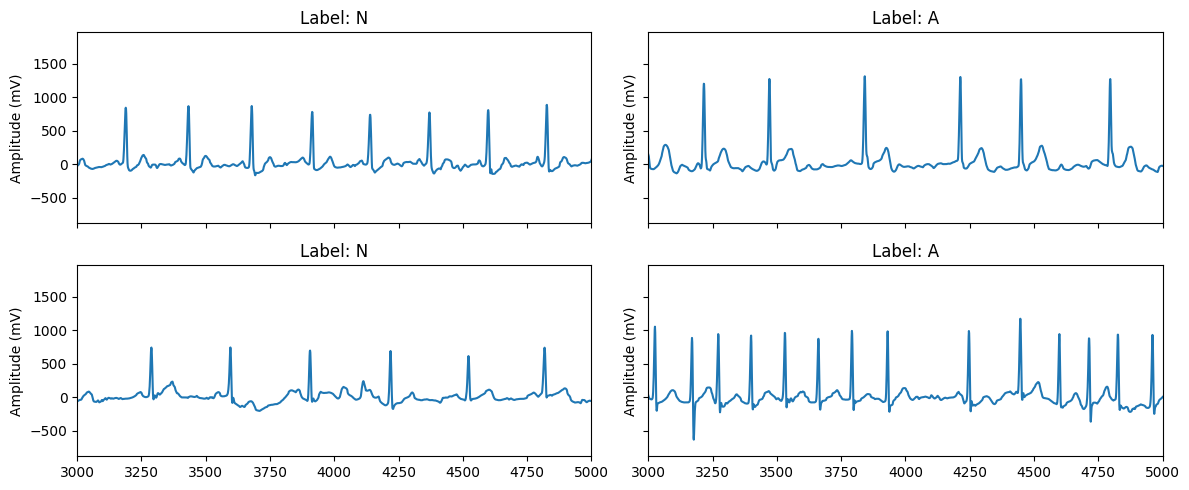

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 5))
for i, idx in enumerate([0, 3, 1, 4]):
    x, y = data[idx]
    ax = axes[i // 2][i % 2]
    ax.plot(x)
    ax.set_title('Label: %s' % data.class_labels[y])
    ax.set_xlim(3000, 5000)
    ax.set_ylabel('Time (frames)')
    ax.set_ylabel('Amplitude (mV)')
plt.tight_layout()

**(e) The class distribution in this dataset is quite unbalanced. What consequences could this have?<span style="float:right"> (1 point)</span>**

The network spends most of the time with the majority class and will not learn a lot about the minority. It might have problems computing a senseful gradient if the minority class is not part of a batch. In the worst case, the network might just always predict the majority class, which will not be punished often, because the minority class is so rare.

## 4.2 Feature extraction

To simplify our poblem a bit, we will convert the 1D ECG signals to [spectrograms](https://en.wikipedia.org/wiki/Spectrogram). A spectrogram is a summary of the frequencies in small windows of the recording. These features will make it easier to train a classification model.

**(a) Run the code to compute the spectrograms.**

In [6]:
class ECGSpectrumDataset(ECGDataset):
    NPERSEG = 32
    NOVERLAP = 32 // 8
    
    def __init__(self, *args, **kwargs):
        # initialize the original dataset to load the samples
        super().__init__(*args, **kwargs)
        # compute and store the spectrograms to replace the samples
        self.compute_spectrum()
    
    def compute_spectrum(self):
        """
        Replaces the samples in this dataset with spectrograms.
        """
        f, t, Sxx = scipy.signal.spectrogram(self.samples.numpy(), scaling='spectrum',
                                             nperseg=self.NPERSEG, noverlap=self.NOVERLAP)
        # normalize the measurements for each frequency
        Sxx = Sxx - np.mean(Sxx, axis=(0, 2), keepdims=True)
        Sxx = Sxx / np.std(Sxx, axis=(0, 2), keepdims=True)
        # replace the existing samples in the dataset with the computed spectrograms
        self.samples = torch.tensor(Sxx.transpose(0, 2, 1))
        # recompute the length of each samples to account for the number of windows
        self.lengths = (self.lengths - self.NPERSEG) // (self.NPERSEG - self.NOVERLAP)

data_spectrum = ECGSpectrumDataset('training2017', class_labels=('N', 'A'))  

**(b) Plot the spectrograms for the four samples from the previous plot.**

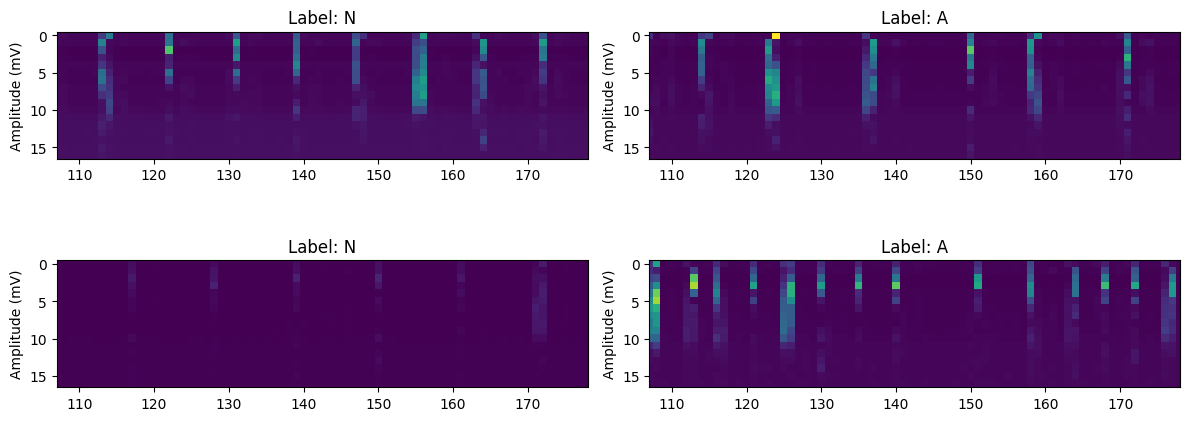

In [7]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate([0, 3, 1, 4]):
    x, y = data_spectrum[idx]
    plt.subplot(2, 2, i + 1)
    plt.imshow(x.T)
    plt.title('Label: %s' % data.class_labels[y])
    # show roughly the same segments as in the previous plot
    plt.xlim(3000 // 28, 5000 // 28)
    plt.ylabel('Amplitude (mV)')
plt.tight_layout()

The spectrogram data has 17 frequency bins for each window. We will use these as our input features. We normalized the data for each frequency to zero mean, unit variance.

**(c) Print the statistics of the spectrum dataset and check the shape of the first sample.**

In [8]:
print('Minimum length: %d' % torch.min(data_spectrum.lengths))
print('Median length:  %d' % torch.median(data_spectrum.lengths))
print('Maximum length: %d' % torch.max(data_spectrum.lengths))
print()
print('Mean value:         %f' % torch.mean(data_spectrum.samples))
print('Standard deviation: %f' % torch.std(data_spectrum.samples))
print()
# print the shape of the first sample
x, y = data_spectrum[0]
print('Shape of first sample:', x.shape)

Minimum length: 141
Median length:  320
Maximum length: 651

Mean value:         0.000327
Standard deviation: 1.003635

Shape of first sample: torch.Size([320, 17])


## 4.3 Splitting training and validation sets

We will split our dataset in separate training and validation sets (80% &ndash; 20%).

**(a) Run the code to create a random split.**

In [9]:
train_samples = int(0.8 * len(data))
val_samples = len(data) - train_samples
data_train_original, data_val_original = torch.utils.data.random_split(data_spectrum, (train_samples, val_samples))

print('data_train:', len(data_train_original))
print('data_val:  ', len(data_val_original))

data_train: 4497
data_val:   1125


## 4.4 Creating a balanced dataset by resampling

As you have seen, the dataset contains far more normal recordings than recordings with atrial fibrillation. We will create a balanced dataset by including multiple copies of the atrial fibrillation samples.

In this assignment we will also use a balanced validation set. This is something you may or may not want to do in practice, because it means that your validation set is no longer representative of the test data. The advantage is that the accuracy on a balanced validation set is easier to compare with the accuracy on the training set.

**(a) Run the code to create balanced training and validation sets.**

In [10]:
def balance_dataset(dataset):
    # collect labels from the source dataset
    labels = torch.zeros((len(dataset),), dtype=torch.long)
    for i, (x, y) in enumerate(dataset):
        labels[i] = y
    indices = torch.arange(len(dataset), dtype=torch.long)

    unique_labels = np.unique(labels.numpy())
    
    # count the number of samples per class
    n = [torch.sum((labels == label).to(torch.long)).item()
         for label in unique_labels]
    
    # perhaps the dataset is already balanced?
    if len(np.unique(n)) == 1:
        return dataset
    
    print('Samples per class:', n)
    for i, label in enumerate(unique_labels):
        # we will add more samples unless every class has the same number of samples
        while n[i] < max(n):
            extra_samples = max(n) - n[i]
            print('- Repeating %d samples for class %d' % (extra_samples, label))

            # take a random subset of samples from this class
            idxs = torch.where(labels == label)[0]
            idxs = idxs[torch.randperm(idxs.shape[0])]
            idxs = idxs[:extra_samples]

            # add these indices to the list
            indices = torch.cat((indices, idxs))
            n[i] += len(idxs)
    
    # return the subset as a new torch dataset
    return torch.utils.data.Subset(dataset, indices)

print('Balancing the training set')
data_train = balance_dataset(data_train_original)
print('Balancing the validation set')
data_val   = balance_dataset(data_val_original)

Balancing the training set
Samples per class: [3952, 545]
- Repeating 3407 samples for class 1
- Repeating 2862 samples for class 1
- Repeating 2317 samples for class 1
- Repeating 1772 samples for class 1
- Repeating 1227 samples for class 1
- Repeating 682 samples for class 1
- Repeating 137 samples for class 1
Balancing the validation set
Samples per class: [979, 146]
- Repeating 833 samples for class 1
- Repeating 687 samples for class 1
- Repeating 541 samples for class 1
- Repeating 395 samples for class 1
- Repeating 249 samples for class 1
- Repeating 103 samples for class 1


## 4.5 Splitting recordings into chunks

The recordings in our dataset all have different lengths and are generally quite long. To simplify training, we will split them into smaller chunks of 40 time steps each. This means that each recording will have multiple chunks in the dataset.

**(a) Run the code to create the pre-chunked dataset.**

In [11]:
class ChunkedDataset(torch.utils.data.TensorDataset):
    def __init__(self, source_dataset, chunk_size=40):
        super().__init__()
        self.make_chunks(source_dataset, chunk_size)
    
    def make_chunks(self, source_dataset, chunk_size):
        all_x, all_y = [], []
        for x, y in source_dataset:
            for chunk in range(x.shape[0] // chunk_size):
                offset = chunk * chunk_size
                all_x.append(x[offset:offset + chunk_size])
                all_y.append(y)
        self.tensors = (torch.stack(all_x), torch.tensor(all_y))

chunked_data_train = ChunkedDataset(data_train_original)
chunked_data_val = ChunkedDataset(data_val_original)

# rebalance to compensate for any differences in length
chunked_data_train = balance_dataset(chunked_data_train)
chunked_data_val   = balance_dataset(chunked_data_val)

print('chunked_data_train:', len(chunked_data_train))
print('chunked_data_val:  ', len(chunked_data_val))

Samples per class: [33999, 4806]
- Repeating 29193 samples for class 1
- Repeating 24387 samples for class 1
- Repeating 19581 samples for class 1
- Repeating 14775 samples for class 1
- Repeating 9969 samples for class 1
- Repeating 5163 samples for class 1
- Repeating 357 samples for class 1
Samples per class: [8427, 1314]
- Repeating 7113 samples for class 1
- Repeating 5799 samples for class 1
- Repeating 4485 samples for class 1
- Repeating 3171 samples for class 1
- Repeating 1857 samples for class 1
- Repeating 543 samples for class 1
chunked_data_train: 67998
chunked_data_val:   16854


## 4.6 Preparing data loaders

As in the previous assignments, we will use the PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) class to divide our datasets in minibatches.

**(a) Run the code to create the data loaders. Look at the shape of the first minibatch.**

In [12]:
batch_size = 192
chunked_loaders = {
    'train': torch.utils.data.DataLoader(chunked_data_train, shuffle=True, batch_size=batch_size),
    'val':   torch.utils.data.DataLoader(chunked_data_val, batch_size=batch_size),
}

# print the x and y shapes for one minibatch
for (x, y) in chunked_loaders['train']:
    print(x.shape, y.shape)
    break

torch.Size([192, 40, 17]) torch.Size([192])


## 4.7 Implementing an LSTM (5 points)

Time series data such as the ECG recordings are a good target for recurrent neural networks (see [Section 9.4](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-networks-with-hidden-states) of the D2L book).

The class below implements an RNN layer in PyTorch, using the equations discussed in [Section 9.4.2](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html#recurrent-networks-with-hidden-states) of the book.

**(a) Read through the code to see how the RNN works.**

In [13]:
class RNN(torch.nn.Module):
    """RNN module.
    
    This implements an RNN module as discussed in Sections 9.4 and 9.5 of the
    the D2L book (http://d2l.ai/chapter_recurrent-neural-networks/rnn.html and
    http://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html).

    Parameters:
       num_inputs:  scalar, the number of inputs to this module
       num_hiddens: scalar, the number of hidden units
    
    Input and output: see the forward function.
    """
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.initialize_parameters()

    def initialize_parameters(self):
        """Initializes the parameters of the RNN module.
        
        This initializes the bias vector b_h and weight matrices W_xh and W_hh.
        """
        def triple():
            return (torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_hiddens))),
                    torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_hiddens, self.num_hiddens))),
                    torch.nn.Parameter(torch.zeros(size=(self.num_hiddens,))))

        # parameters for the rnn
        self.W_xh, self.W_hh, self.b_h = triple()

    def forward(self, inputs):
        """Computes the forward pass of the RNN module.
        
        Input:
           inputs:  a tensor of shape (samples, steps, input features)
                    giving the input for each sample at each step
        
        Output:
           outputs: a tensor of shape (samples, steps, hidden features)
                    providing the hidden values at the end of each step
           state:   a tuple (hiddens,)
                    the state of the RNN at the end of the last step,
                    with hiddens a tensor of shape (samples, hidden_features)
        """
        batch_size = inputs.shape[0]

        # initialize state
        state = (torch.zeros(size=(batch_size, self.num_hiddens),
                             dtype=inputs.dtype, device=inputs.device),)

        # run steps
        outputs = []
        for step in range(inputs.shape[1]):
            state = self.one_step(inputs[:, step], state)
            outputs.append(state[0])

        # concatenate outputs
        outputs = torch.stack(outputs, axis=1)
        return outputs, state

    def one_step(self, x, state):
        """Run a single step of the RNN module.
        
        Input:
           x:     a tensor of shape (samples, input features)
                  giving the input for each sample at the current step
           state: a tuple (hiddens,)
                  the state of the RNN at the end of the previous step,
                  with hiddens a tensor of shape (samples, hidden_features)
        """
        # extract current state
        (h,) = state

        # see http://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html#rnn-model

        # new hidden
        h = torch.tanh(torch.mm(x, self.W_xh) + torch.mm(h, self.W_hh) + self.b_h)

        # return the state
        return (h,)

    def __repr__(self):
        return ('RNN(num_inputs=%d, num_hiddens=%d)' %
                (self.num_inputs, self.num_hiddens))


# quick sanity check
rnn = RNN(3, 5)
print(rnn)
print('Parameters:')
for name, param in rnn.named_parameters():
    print(' - %s:' % name, tuple(param.shape))

RNN(num_inputs=3, num_hiddens=5)
Parameters:
 - W_xh: (3, 5)
 - W_hh: (5, 5)
 - b_h: (5,)


The design of the LSTM module is more complex than that of the RNN, but it follows a similar pattern of looping over all steps in the input. You can use the RNN implementation as a basis for an LSTM module.

**(b) Implement the LSTM module below.<span style="float:right"> (5 points)</span>**

The equations and code in [Section 10.1](http://d2l.ai/chapter_recurrent-modern/lstm.html) can provide some inspiration. Be aware that the book uses `(steps, samples, ...)` instead of `(samples, steps, ...)` as the shapes for the input and output variables, so you probably cannot copy code directly. Use the RNN implementation above and adapt this to the LSTM equations from the book.

In [14]:
class LSTM(torch.nn.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.initialize_parameters()

    def initialize_parameters(self):
        def triple():
            return (torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_inputs, self.num_hiddens))),
                    torch.nn.Parameter(torch.normal(0, 0.01, size=(self.num_hiddens, self.num_hiddens))),
                    torch.nn.Parameter(torch.zeros(size=(self.num_hiddens,))))

        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, inputs):
        H = torch.zeros((inputs.shape[0], self.num_hiddens), device=inputs.device, dtype=inputs.dtype)
        C = torch.zeros((inputs.shape[0], self.num_hiddens), device=inputs.device, dtype=inputs.dtype)

        outputs = []
        for step in range(inputs.shape[1]):
            C, H = self.one_step(inputs[:, step], H, C)
            outputs.append(H)

        outputs = torch.stack(outputs, axis=1)
        return outputs, H
        

    def one_step(self, x, state, memory):
        I = torch.sigmoid(torch.matmul(x, self.W_xi) + torch.matmul(state, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(x, self.W_xf) + torch.matmul(state, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(x, self.W_xo) + torch.matmul(state, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(x, self.W_xc) + torch.matmul(state, self.W_hc) + self.b_c)
        C = F * memory + I * C_tilde
        H = O * torch.tanh(C)
        
        return C, H
        

    def __repr__(self):
        return ('LSTM(num_inputs=%d, num_hiddens=%d)' %
                (self.num_inputs, self.num_hiddens))


# quick sanity check
lstm = LSTM(3, 5)
print(lstm)
for name, param in lstm.named_parameters():
    print(' - %s:' % name, tuple(param.shape))

LSTM(num_inputs=3, num_hiddens=5)
 - W_xi: (3, 5)
 - W_hi: (5, 5)
 - b_i: (5,)
 - W_xf: (3, 5)
 - W_hf: (5, 5)
 - b_f: (5,)
 - W_xo: (3, 5)
 - W_ho: (5, 5)
 - b_o: (5,)
 - W_xc: (3, 5)
 - W_hc: (5, 5)
 - b_c: (5,)


## 4.8 Defining the training loop

As last week, we need to define some functions to run the train the models.

**(a) Run the code to define the functions.**

In [15]:
def accuracy(y_hat, y):
    # Computes the mean accuracy.
    # y_hat: raw network output (before sigmoid or softmax)
    #        shape (samples, classes)
    # y:     shape (samples)
    if y_hat.shape[1] == 1:
        # binary classification
        y_hat = (y_hat[:, 0] > 0).to(y.dtype)
    else:
        # multi-class classification
        y_hat = torch.argmax(y_hat, axis=1).to(y.dtype)
    correct = (y_hat == y).to(torch.float32)
    return torch.mean(correct)

In [16]:
def train(net, data_loaders, epochs=100, lr=0.01, device=d2l.try_gpu()):
    # Trains the model net with data from the data_loaders['train'] and data_loaders['val'].
    net = net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train loss', 'train acc', 'validation loss', 'validation acc'],
                            figsize=(10, 5))

    timer = {'train': d2l.Timer(), 'val': d2l.Timer()}

    for epoch in range(epochs):
        # monitor loss, accuracy, number of samples
        metrics = {'train': d2l.Accumulator(3), 'val': d2l.Accumulator(3)}

        for phase in ('train', 'val'):
            # switch network to train/eval mode
            net.train(phase == 'train')

            for i, (x, y) in enumerate(data_loaders[phase]):
                timer[phase].start()

                # move to device
                x = x.to(device)
                y = y.to(device)

                # compute prediction
                y_hat = net(x)
                
                if y_hat.shape[1] == 1:
                    # compute binary cross-entropy loss
                    loss = torch.nn.BCEWithLogitsLoss()(y_hat[:, 0], y.to(torch.float))
                else:
                    # compute cross-entropy loss
                    loss = torch.nn.CrossEntropyLoss()(y_hat, y)

                if phase == 'train':
                    # compute gradients and update weights
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                metrics[phase].add(loss * x.shape[0],
                                   accuracy(y_hat, y) * x.shape[0],
                                   x.shape[0])

                timer[phase].stop()

        animator.add(epoch + 1,
            (metrics['train'][0] / metrics['train'][2],
             metrics['train'][1] / metrics['train'][2],
             metrics['val'][0] / metrics['val'][2],
             metrics['val'][1] / metrics['val'][2]))

    train_loss = metrics['train'][0] / metrics['train'][2]
    train_acc  = metrics['train'][1] / metrics['train'][2]
    val_loss   = metrics['val'][0] / metrics['val'][2]
    val_acc    = metrics['val'][1] / metrics['val'][2]
    examples_per_sec = metrics['train'][2] * epochs / timer['train'].sum()
    
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{examples_per_sec:.1f} examples/sec '
          f'on {str(device)}')

## 4.9 Constructing some networks (5 points)

In the next experiments you will train different network architectures to see how they perform on the ECG dataset.

The input to all networks has the shape (samples, time steps, features) = (mb_size, 40, 17). The output should be a single feature, shape (mb_size, 1), that will be used in a binary cross-entropy loss function. (The networks should not include the final sigmoid activation function.)

Some simple baselines:
* `FullyConnectedNet`: A simple fully connected network that takes all features.
* `MeanSpectrumNet`: A fully connected network that works on the mean spectrum over all time steps.

A convolutional network:
* `ConvNet`: This network does a convolution over the time steps, using the 17 input features as channels.

Some recurrent models:
* `RNNNet`: A recurrent network with a simple RNN module.
* `LSTMNet`: A recurrent network with a more advanced LSTM module.
* `TorchLSTMNet`: The same model, but using the PyTorch implementation of the LSTM.

### FullyConnectedNet

**(a) Check the implementation of the following baseline architecture:**

* Linear layer: network inputs to 512 units followed by a ReLU.
* Linear layer: 512 to 256 units followed by a ReLU.
* Linear layer: 256 to the network output.

In [17]:
class FullyConnectedNet(torch.nn.Module):
    def __init__(self, inputs, outputs=1):
        super().__init__()

        # by defining these layers here, they are included in the
        # parameters() list of this module, so they can be trained
        self.linear = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(inputs, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        return self.linear(x)

net = FullyConnectedNet(40 * 17)
print(net)

FullyConnectedNet(
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=680, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=1, bias=True)
  )
)


### MeanSpectrumNet

**(b) Check the implementation of the following baseline architecture:**

* Compute the mean spectrum (mean over the steps dimension).
* Linear layer: network inputs to 128 units followed by a ReLU.
* Linear layer: 128 to 64 units followed by a ReLU.
* Linear layer: 64 to the network output.

In [18]:
class MeanSpectrumNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, outputs),
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # compute the mean over all steps
        x = torch.mean(x, axis=1)
        return self.net(x)

net = MeanSpectrumNet()
print(net)

MeanSpectrumNet(
  (net): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### ConvNet

**(c) Complete the implementation of the following architecture:<span style="float:right"> (1 point)</span>**

Convolution over the steps, using frequencies as channels:
* 1D-convolution: network inputs to 32 channels, kernel size 3, ReLU.
* Average pooling: 2.
* 1D-convolution: 32 to 64 channels, kernel size 3, ReLU.
* Average pooling: 2.
* 1D-convolution: 64 to 128 channels, kernel size 3, ReLU.
* `AdaptiveAvgPool1d(1)`: Compute the mean for each channel over all steps.
* Flatten.
* Linear layer: 128 to the network output.

In [19]:
class ConvNet(torch.nn.Module):
    def __init__(self, inputs=1, outputs=1):
        super().__init__()

        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(inputs, 32, kernel_size=3), torch.nn.ReLU(),
            torch.nn.AvgPool1d(2),
            torch.nn.Conv1d(32, 64, kernel_size=3), torch.nn.ReLU(),
            torch.nn.AvgPool1d(2),
            torch.nn.Conv1d(64, 128, kernel_size=3), torch.nn.ReLU(),
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(128, outputs),
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        # swap the steps and inputs dimensions, so we can convolve over
        # the steps use the frequencies as channels
        x = x.transpose(2, 1)
        return self.net(x)

net = ConvNet()

### RNNNet

**(d) Check the implementation of the following architecture:**

* RNN: network input to 128 hidden units.
* Use the final hidden state from the RNN.
* Linear layer: 128 to 128 units followed by a ReLU.
* Linear layer: 128 to the network output.

In [20]:
class RNNNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.rnn = RNN(inputs, 128)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )
        
    def forward(self, x):
        # x shape: (samples, steps, inputs)
        out, (h,) = self.rnn(x)
        
        # use the final RNN hidden state as input
        # for the fully connected part
        return self.linear(h)

net = RNNNet()
print(net)

RNNNet(
  (rnn): RNN(num_inputs=17, num_hiddens=128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


### LSTMNet

**(e) Implement the following architecture: (see RNNNet for an example)<span style="float:right"> (2 points)</span>**

* LSTM: network input to 128 hidden units.
* Use the final hidden state from the LSTM.
* Linear layer: 128 to 128 units followed by a ReLU.
* Linear layer: 128 to the network output.

In [21]:
class LSTMNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.lstm = LSTM(inputs, 128)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )

    def forward(self, x):
        # x shape: (samples, steps, inputs)
        _, H = self.lstm(x)
        
        return self.linear(H)

net = LSTMNet()
print(net)

LSTMNet(
  (lstm): LSTM(num_inputs=17, num_hiddens=128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


### TorchLSTMNet

Implementing your own modules can be fun and good learning experience, but it is not always the most efficient solution. The built-in [LSTM implementation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) from PyTorch is much faster than our own version.

**(f) Implement a network similar to LSTMNet using the PyTorch torch.nn.LSTM module.<span style="float:right"> (2 points)</span>**

In [22]:
class TorchLSTMNet(torch.nn.Module):
    def __init__(self, inputs=17, outputs=1):
        super().__init__()

        self.lstm = torch.nn.LSTM(input_size=inputs, hidden_size=128,  batch_first=True)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, outputs)
        )

    def forward(self, x):
        # x shape: (samples, steps, inputs)
        _, (H, _) = self.lstm(x)

        return self.linear(torch.squeeze(H))

net = TorchLSTMNet()
print(net)

TorchLSTMNet(
  (lstm): LSTM(17, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


## 4.10 Experiments

**(a) Train the models on the chunked dataset.**

train loss 0.556, train acc 0.698, val loss 2.662, val acc 0.570
164782.5 examples/sec on cuda:0


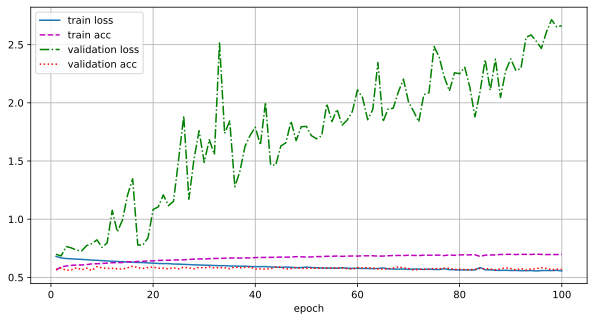

In [23]:
train(MeanSpectrumNet(), chunked_loaders, epochs=100, lr=0.01)

train loss 0.056, train acc 0.984, val loss 17.174, val acc 0.779
149546.7 examples/sec on cuda:0


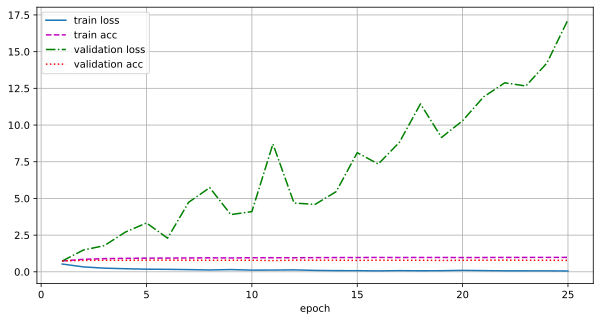

In [24]:
train(FullyConnectedNet(40 * 17), chunked_loaders, epochs=25, lr=0.01)

train loss 0.064, train acc 0.978, val loss 0.879, val acc 0.876
133270.8 examples/sec on cuda:0


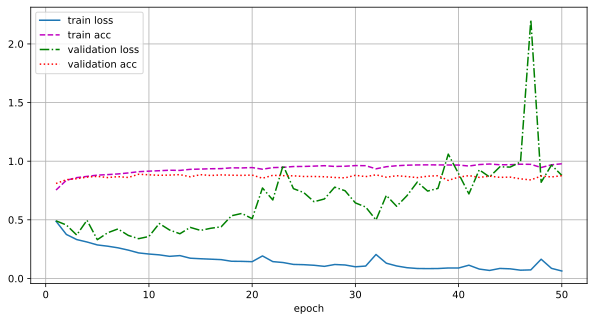

In [25]:
train(ConvNet(17), chunked_loaders, epochs=50, lr=0.01)

train loss 0.689, train acc 0.526, val loss 0.697, val acc 0.525
43278.5 examples/sec on cuda:0


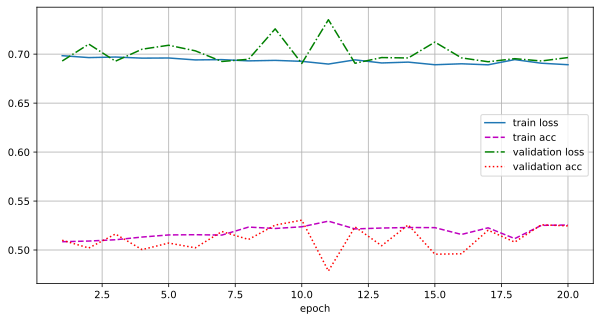

In [26]:
train(RNNNet(17), chunked_loaders, epochs=20, lr=0.01)

train loss 0.088, train acc 0.968, val loss 0.380, val acc 0.891
11486.4 examples/sec on cuda:0


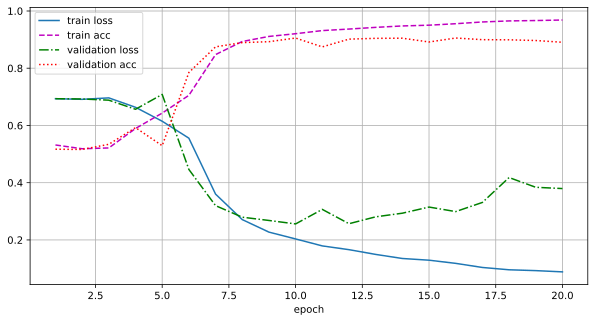

In [27]:
train(LSTMNet(17), chunked_loaders, epochs=20, lr=0.01)

train loss 0.043, train acc 0.986, val loss 0.588, val acc 0.883
40188.1 examples/sec on cuda:0


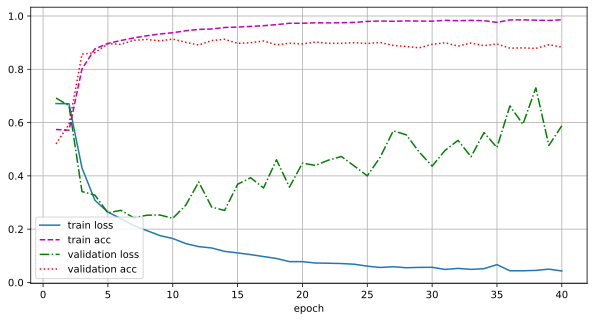

In [28]:
train(TorchLSTMNet(17), chunked_loaders, epochs=40, lr=0.01)

## 4.11 Discussion (11 points)

**(a) Briefly discuss and compare the performance of the models in your experiments. Which worked best and why?<span style="float:right"> (2 points)</span>**

* *MeanSpectrumNet*: The MeanSpectrumNet performance is very bad. It overfits very much. The validation accuracy is at about 50%, which means that with a balanced validation data set, as we use it, it is not better than guessing.
* *FullyConnectedNet*: The FullyConnectedNet is also clearly overfitting, which we can see in a very low train loss and a high train-accuracy, while the validation loss is constantly increasing and the validation accuracy is trapped at about 77%. Considering that 50% accuracy is achieved by guessing, this is not a good accuracy.
* *ConvNet*: While the ConvNet is still clearly overfitting, it performs way better than the previous networks. We can achieve a validation accuracy of about 86%.
* *RNNNet*: The RNNNet does not seem to learn anything. It seems to be converged right from the beginning with a validation accuracy equivalent to guessing.
* *(Torch)LSTMNet*: The LSTMNet outperforms all the previous networks, but it is still overfitting, which we can see in a diverging validation a training loss. The maximum validation accuracy that we get is about 90%.

As mentioned, the LSTM does perform the best, which is probably because its architecture is most suited for sequential/time-series data. Tt seems important to have a separate memory and input weighting, which could be a reason that the LSTM performs way better than the RNN.

**(b) Why do some of those models generalize better than others?<span style="float:right"> (2 points)</span>**

The LSTM generalizes better, because the architecture is built for sequential data, and it has a memory that it can use to remember what heartbeats came before.
The CNN generalizes better that others, because it can convolve over time, to get the general patterns out of the heartbeat data.

The LSTM and CNN are forced to use way fewer features to pass on the next LSTM-node or layer, respectively. This enables the networks to concentrate on specific time frames that are relevant for the detection.

**(c) How does your LSTM implementation compare with the PyTorch implementation?<span style="float:right"> (1 point)</span>**

While the charts look very similar, the torch implementation ran about 3.5x faster than our own implementation.

**(d) Your RNN model probably didn't work well. Why is that model more difficult to train than the LSTM?<span style="float:right"> (1 point)</span>**

The problem might be related to vanishing gradients, which results in the network not learning anything.

**(e) The convolutional network and the LSTM in these experiments both work on the time dimension. What is an advantage of the convolutional network over the LSTM?<span style="float:right"> (1 points)</span>**

One big advantage is that it trains about 3.2x faster than the torch LSTM. This advantage is reduced by the fact that it requires more epochs to converge, but still the Convolutional network trains faster than the LSTM.

**(f) What is an advantage of the LSTM over a convolutional network?<span style="float:right"> (1 points)</span>**

The LSTM generalizes better and has a higher validation accuracy compared to the convolutional network.

**(g) For reasons of speed, we used a fairly small window of 40 time steps. Suppose that we would make this window much larger. How do you think this would affect each model?<span style="float:right"> (2 points)</span>**

* *MeanSpectrumNet*: The MeanSpectrumNet is still not made for time series data, and thus will probably not profit a lot from bigger time frames.
* *FullyConnectedNet*: The FullyConnectedNet is still not made for time series data, and thus will probably not profit a lot from bigger time frames.
* *ConvNet*: The ConvNet will probably not change a lot, as the receptive field stays the same.
* *RNNNet*: The RNNNet will probably still suffer from vanishing gradients and not learn anything.
* *(Torch)LSTMNet*: The LSTM would probably profit from a larger time window, as it can use the time series for better predictions.

**(h) One of the difficulties with recurrent networks is that inputs from early steps are quite far away from the final result. How would you suggest to reduce that problem?<span style="float:right"> (1 point)</span>**

Bidirectional RNNs might help; as this way, we get information from both sides, making the general distance smaller.

## 4.12 Data augmentation

Especially if your dataset is small, data augmentation can help to improve the performance of your network.

We have an easy way to add some data augmentation to the ECG dataset. In our preprocessing, we divided each recording into small chunks of 40 time steps, which we then reused in every epoch. We can add more variation to the training set by creating chunks at random positions.

The [DataLoader](https://pytorch.org/docs/stable/data.html) class in PyTorch has a `collate_fn` parameter to which we can pass a function. This function is called for each minibatch in each epoch. We will use this to extract a random chunk from each sample.

The function `random_chunk_collate_fn` takes a minibatch of samples, chooses a random offset for each sample, extracts a small chunk at that position, and then concatenates and returns the result.

In [29]:
def random_chunk_collate_fn(samples, window_size):
    # Take a list of tensors of (steps_i, features),
    # extract a random window of length window_size from each tensor,
    # concatenate to a tensor of shape (samples, window_size, features).
    x_batch = torch.empty((len(samples), window_size) + samples[0][0].shape[1:],
                          device=samples[0][0].device, dtype=samples[0][0].dtype)
    y_batch = torch.empty((len(samples),),
                          device=samples[0][1].device, dtype=samples[0][1].dtype)
    for i, (x, y) in enumerate(samples):
        # extract a random window
        offset = torch.randint(x.shape[0] - window_size, (1,))
        x_batch[i, :] = x[offset:offset + window_size]
        y_batch[i] = y
    return x_batch, y_batch

We construct a new DataLoader for our training set:

In [30]:
# test to see the x and y shapes for one sample
random_chunk_loaders = {
    'train': torch.utils.data.DataLoader(data_train, shuffle=True, batch_size=batch_size,
                                         collate_fn=lambda s: random_chunk_collate_fn(s, window_size=40)),
    'val':   chunked_loaders['val']
}
for (x, y) in random_chunk_loaders['train']:
    print(x.shape, y.shape)
    break

torch.Size([192, 40, 17]) torch.Size([192])


Observe that the pre-chunked dataset was much larger than the new dataset with on-the-fly chunking. You might want to increase the number of training epochs a bit to make sure that the network sees a similar number of examples.

In [31]:
print('Minibatches in chunked_loader[\'train\']:      ', len(chunked_loaders['train']))
print('Minibatches in random_chunk_loaders[\'train\']:', len(random_chunk_loaders['train']))

Minibatches in chunked_loader['train']:       355
Minibatches in random_chunk_loaders['train']: 42


Let's see how this data augmentation method affects the performance of your networks.

**(a) Train the MeanSpectrumNet, FullyConnectedNet, ConvNet and TorchLSTMNet from the previous experiments on data from the `random_chunk_loaders`.**

train loss 0.650, train acc 0.616, val loss 0.770, val acc 0.570
154067.8 examples/sec on cuda:0


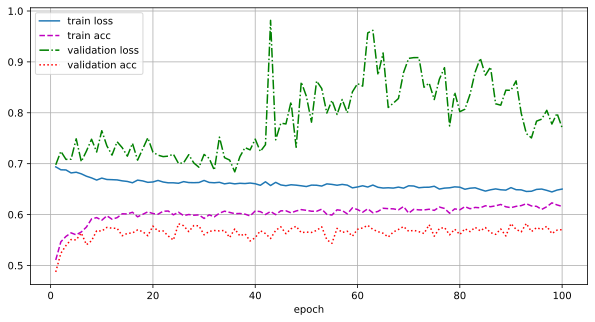

In [32]:
train(MeanSpectrumNet(), random_chunk_loaders, epochs=100, lr=0.01)

train loss 0.371, train acc 0.839, val loss 0.368, val acc 0.843
132244.2 examples/sec on cuda:0


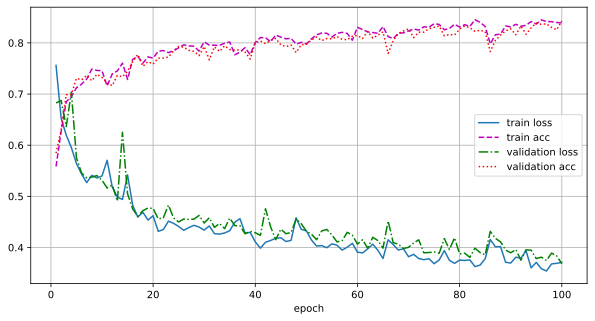

In [33]:
train(FullyConnectedNet(40 * 17), random_chunk_loaders, epochs=100, lr=0.01)

train loss 0.289, train acc 0.880, val loss 0.373, val acc 0.846
112658.4 examples/sec on cuda:0


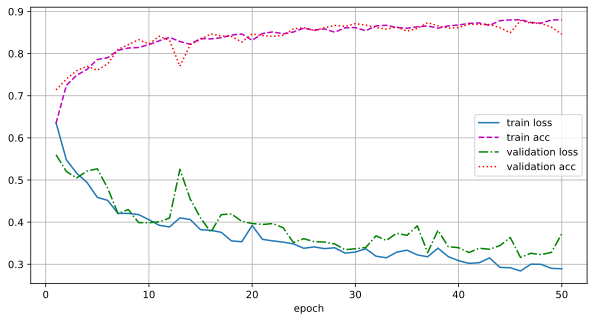

In [34]:
train(ConvNet(17), random_chunk_loaders, epochs=50, lr=0.01)

train loss 0.125, train acc 0.952, val loss 0.177, val acc 0.936
40707.5 examples/sec on cuda:0


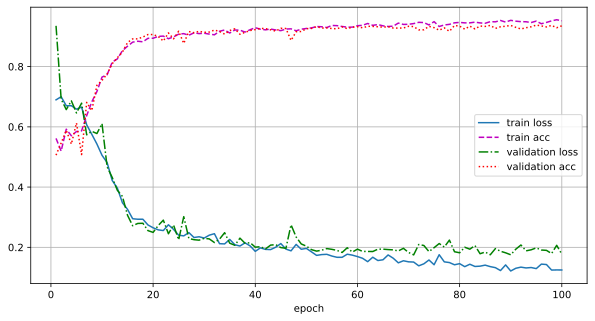

In [35]:
train(TorchLSTMNet(17), random_chunk_loaders, epochs=100, lr=0.01)

## 4.13 Discussion (9 points)

**(a) How does the data augmentation influence the training and validation results? Can you explain this?<span style="float:right"> (2 points)</span>**

The training loss becomes bigger, the training accuracy goes down, but the validation loss gets smaller and the validation accuracy increases, compared to the networks without data augmentation.

This is because the model cannot overfit to the training data that much anymore, as it sightly changes very epoch.

**(b) Why does the data augmentation affect some models more than others?<span style="float:right"> (1 point)</span>**

- The mean is not changes as much by the slight changes, which makes the MeanSpectrumNet to not profit a lot.
- The LSTM already performed comparably well without data augmentation, and thus could not improve as much. Additionally, it is designed for sequences, and thus less prone to overfit on them.
- The fully connected network profited the most, as it can generalize much better with slight changes in the input data.
- The CNN was already comparably good, but the overfiting could be significantly reduced by the data augmentation.

**(c) Should we also do data augmentation on the validation set? Why, or why not?<span style="float:right"> (1 point)</span>**

No, we should not do the data augmentation on the validation set, as we don't want to judge a model by its performance that does not occur in the real world.

**(d) Data augmentation is often a good way to add some domain knowledge to your model. Based on your knowledge of ECGs, why is (or isn't) our augmentation method a good idea?<span style="float:right"> (1 point)</span>**

The data augmentation we do seems to be a good way in this specific case, as we do not actually modify the data, but only take some standalone part out of it. 

**(e) Give an example of another suitable augmentation method and explain why it would work for this data.<span style="float:right"> (2 points)</span>**

Change the "replay" speed of the ECG by a bit.

**(f) Give an example of an augmentation method that might be suitable for other data but would probably not work here. Explain why.<span style="float:right"> (2 points)</span>**

An augmentation method that would be unsuitable for our domain would be adding noise to the data, i.e. inserting random heartbeats into a sequence. This would be a very bad idea, because if we were to add noise into the data in the form of extra inserted or concatenated heartbeats, we might accidentally insert an augmented heartbeat in a sequence of regular heartbeats that would make the sequence irregular, without appropriately changing the label. If our model trained on this data, not only would it be less effective, but it would learn to recognize irregular heartbeats as regular. This is terrible from the perspective of the domain: we do not want for someone with an irregular heartbeat to be diagnosed with a regular heartbeat; that could have dire medical consequences.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 31 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 7bd5a19 / 2023-09-25</span>